### Introduction

Both of the challenges involve thorough understanding of the whole algorithm as well as the problem in hand. The first problem focuses on the computer vision aspect of AI and the second problen focuses on the NLP aspect, both of which are the core of any Machne Learning based application.

These are interesting problems to begin with because without an appropriate approach to these problems, the output would just be a bunch of numbers, with little or no value.

The first problem urges us to think beyond the problem and focus more on the process. A large run of epochs would obviously resuult in better training accuracy, but it's not an ideal way to deal with this problem as it is resource intensive to run large number of epochs and, most importanly, it's always prone to get overfit on the training data and tend to form strong relations in training data and hence starts to "remember" the training data. Such kind of models will most certainly perform poorly on the validaition and test set data, even if they seemed to perfomred very well on the training data.

#### SOTA:
The state of the art (SOTA) model used on the same dataset gives an accuracy of 99.74% [[source](https://paperswithcode.com/sota/fine-grained-image-classification-on-oxford)]. If we are careful with our approach, we should be able to achieve an accuracy close to this score since now we know it is possible to do so.

### Downloading the Dataset

To get the dataset in our colab environment, we are going to download it from the link provided. We are going to use the wget package to downaload the dataset file.

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz

--2020-11-10 07:49:22--  https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.68.158
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.68.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345236087 (329M) [application/x-tar]
Saving to: ‘oxford-102-flowers.tgz’

oxford-102-flowers. 100%[===================>] 329.24M  17.0MB/s    in 21s     

2020-11-10 07:49:44 (15.4 MB/s) - ‘oxford-102-flowers.tgz’ saved [345236087/345236087]



#### Extracting data

We're first making a directory called 'data' to store the downloaded data.

Then we change the current working directory using the %cd magic command

Using the 'tar' package, we will extract the data from the downloaded dataset and store the images in the file system of colab environment.

And finally, after the extraction of data, we will delete the downloaded tgz file to save memory

In [ ]:
!mkdir '/content/data'
%cd data
!tar -zxvf /content/oxford-102-flowers.tgz
!rm -rf /content/oxford-102-flowers.tgz

### Importing libraries

A bit about each library is as follows:
1. **torch**: contain all the PyTorch impelemenatation of various kinds of neural networks and other related thinigs
2. **torchvision**: The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision
3. **numpy**: It's an array manipluation library which supports n-dimentional arrays and provides very handy high-level mathematical functions
4. **matplotlib**: It's a library to create and display visualizations
5. **time**, **os**, **copy**: These are utility libraries for certain operations as we will see below

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time
import os
import copy
import tree

Now, to make sure we leverage the performance of GPUs, we are preparing a variable called 'device' to make the future computations on the GPU instead of the CPU

In [ ]:
#Testing if we have access to GPU, for faster processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Loading Dataset in memory

The dataset contains 102 categories of flowers. Each class consists of between 40 and 258 images.

We are provided with three files namely '**train.txt**', '**valid.txt**' and '**test.txt**' containing the names of train, validation and test set images along with their respective categories

To load the datasets, it becomes convenient to have the train, validation and test data in their own seperate folders, so that they can then be loaded into the memory with the help of PyTorch's *ImageFolder* functionality.

In [ ]:
data_dir = '/content/data/oxford-102-flowers/'
files = ['train.txt','test.txt','valid.txt']

for i in files:
  with open(data_dir + i) as myfile:
    for line in myfile:
      curr = i.split('.')[0]
      l = line.split()
      src = os.path.join(data_dir + l[0])

      dir = os.path.join(data_dir + curr)
      if not os.path.isdir(dir):
        os.mkdir(dir)
      
      sub_dir = os.path.join(dir + '/' + l[1])
      if not os.path.isdir(sub_dir):
        os.mkdir(sub_dir)

      os.system('cp "%s" "%s"' % (src, sub_dir))
print("All files copied to the subfolders")

All files copied to the subfolders


In [ ]:
#Tree package used for visualizing the directory structure
%cd /content/
!tree -d -L 3

/content
.
├── data
│   └── oxford-102-flowers
│       ├── jpg
│       ├── test
│       ├── train
│       └── valid
└── sample_data

7 directories


Now, let's finally load the data in memory

In [ ]:
#Converting PIL images to Tensors for processing
#Random cropping is used to make all the input image size of constant size

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ])
}

#Using the ImageFolder to make the image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                                          for x in ['train', 'valid', 'test']}

#Creating dataloaders for efficient retrieval of image data
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}

Let's see if the images are in place. We should see 1020 images in each of the 'train' and 'valid' subfolders as there are 1020 lines in each of the train.txt and valid.txt files

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

print(dataset_sizes)

{'train': 1020, 'valid': 1020}


As expected, we have the train and valid datasets in place, as required.

We can also have all the flower categories that are present. We are storing the same in the list 'class_names'

In [ ]:
class_names = image_datasets['train'].classes

### Visualizing sample images

Now, let's take random sample of data and visualize it

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

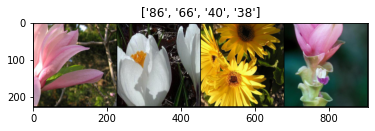

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Checking imbalance in data

Imbalance in data is caused when some of the classes have too many or too few data relative to the other classes, causing the model to either overfit or underfit on these particular classes. This is one of the main reason that affects the model's performance. This is very prominent in real-world scenarios where the data is highly imbalanced.

Let's see if our training data is imbalanced or not

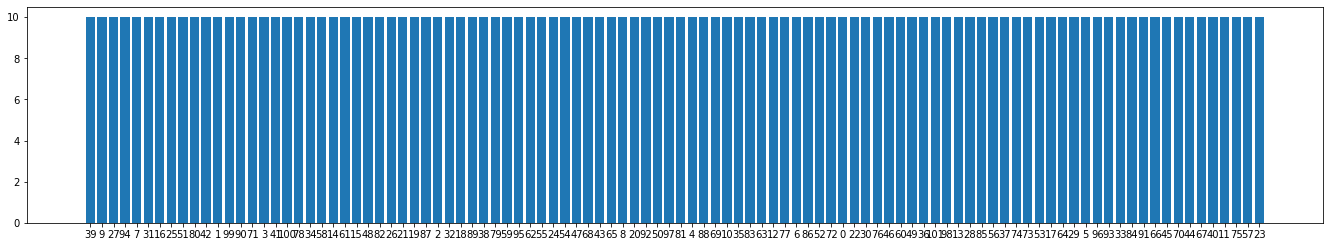

In [ ]:
path = '/content/data/oxford-102-flowers/train'
directory=os.listdir(path)
samples = []

for i in directory:

  currentFolder = path + '/' + i

  _, _, files = next(os.walk(currentFolder))
  samples.append(len(files)) 

fig = plt.figure(figsize=(18,3))
ax = fig.add_axes([0,0,1,1])
labels = directory
ax.bar(labels,samples)
plt.show()

Great! The training data is very well balanced since each class contains exactly 10 number of samples.

### Training the Model

We are required to use a pre-trained model of ResNet 50 with atmost 10 epochs.

Let's first build some general functions to train the model

*Directly borrowed from [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)*

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate/validation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Finetuning the model

*Directly borrowed from [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)*

Here we are using the pretrained resnet50 model and replacing its last layer with our own linear layer that outputs the total number of class names (labels) we have for our own data, i.e. 102

To use the pretrained model of resnet, we set the pretrained parameter to be true.


In [ ]:
model_ft = models.resnet50(pretrained=True)

Now to see how many features does the last fully connected layer of resnet has, we need to print the summary of the model

In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

As we cam see, the last 'fc' layer has 2048 features. We can access this value directly by doing the following:

In [ ]:
num_ftrs = model_ft.fc.in_features
num_ftrs

2048

Now, we simply need to replace the last fc layer of resnet with our own layer and then simply set the loss and optimizer as well as the learning rate scheduler

In [ ]:
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Now we have a fine-tuned resnet50 model alterted for our own use case. We can begin the training now

Training and evaluating the model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 4.5505 Acc: 0.0441
valid Loss: 3.3363 Acc: 0.3108
Epoch 1/9
----------
train Loss: 3.4051 Acc: 0.2196
valid Loss: 2.0474 Acc: 0.4696
Epoch 2/9
----------
train Loss: 2.5463 Acc: 0.3931
valid Loss: 1.5407 Acc: 0.6118
Epoch 3/9
----------
train Loss: 1.9549 Acc: 0.5353
valid Loss: 1.1659 Acc: 0.6902
Epoch 4/9
----------
train Loss: 1.4789 Acc: 0.6706
valid Loss: 1.1781 Acc: 0.6931
Epoch 5/9
----------
train Loss: 1.3097 Acc: 0.6931
valid Loss: 1.0731 Acc: 0.7245
Epoch 6/9
----------
train Loss: 1.0589 Acc: 0.7657
valid Loss: 0.9071 Acc: 0.7676
Epoch 7/9
----------
train Loss: 0.7754 Acc: 0.8441
valid Loss: 0.6380 Acc: 0.8343
Epoch 8/9
----------
train Loss: 0.6825 Acc: 0.8804
valid Loss: 0.6029 Acc: 0.8402
Epoch 9/9
----------
train Loss: 0.6272 Acc: 0.8941
valid Loss: 0.6302 Acc: 0.8431
Training complete in 8m 31s
Best val Acc: 0.843137


Visualizing the model *predictions*

Generic function to display predictions for a few images

*Directly borrowed from [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)*

Now, we are interested to see if our model correctly predicts a sample of test data, the data that it hasn't seen before. The 'predicted' value is the category that our model has predicted and the 'actual' value is the ground truth value of the image.

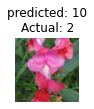

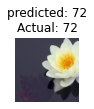

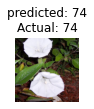

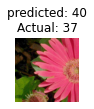

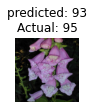

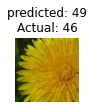

In [ ]:
def visualize_model(model, num_images=6, dataloaders=dataloaders['test']):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}\nActual: {}'.format(class_names[preds[j]], labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)

As we can see, ony 2 out of 6 sample images are predcited correctly. Let's see the total accuracy on the entire test set of our data.

In [ ]:
correct = 0
total = 0
was_training = model_ft.training
model_ft.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs).to(device)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    model_ft.train(mode=was_training)

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 82 %


We got an accuracy of 82%, which is pretty good for what little effort we have done to build our model so far. But, it's no where near the SOTA models, which are all above 98% (top 10)

Let's now explore how we can improve our model

### Disecting the results

Let's see the misclassified images from the above visualizations and inspect them to see if we can find out anything.

The first misclassified image was of category 2, which was predicted to be of category 10.

The second misclassified image was of category 37, which was predicted to be of category 40.

and so on...

 Let's see some sample images of all these classes

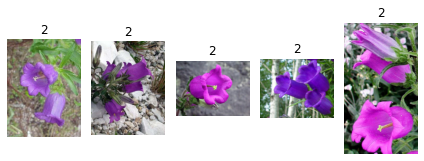

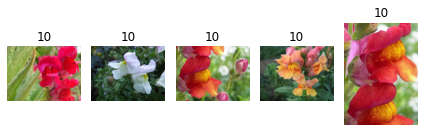

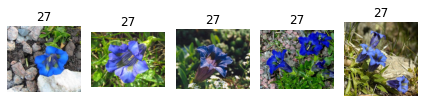

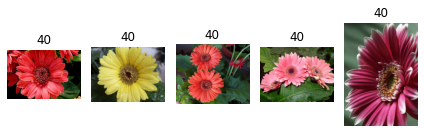

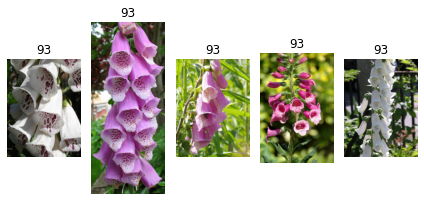

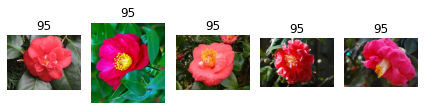

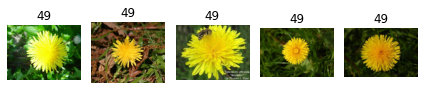

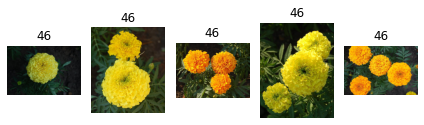

In [ ]:
path = '/content/data/oxford-102-flowers/test'
classes = [2, 10, 27, 40, 93, 95, 49, 46]

for each in classes:
    plt.figure()
    currentFolder = path + '/' + str(each)
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = path + "/" + str(each) + '/' + file
        img=mpimg.imread(fullpath)
        plt.subplot(1, 5, i+1)
        plt.title(each)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(img)

*Note: The predicted and actual classes are plotted one after the other.*

Observations from the above visualizations:
1. We can see that, all the mislabeled classes have some things in common. Such as, the class 2-10, 27-40 and 49-46 have very similar petal shapes.
2. It looks like the model is ignoring the factor of color in the 2-10 misclassification since the most prominent factor that distinguishes these 2 classes are their colours. Similarily, the model seems to correlate the colors of the 49-46 pair.
3. It's very clear that the model still has to learn various features that distinguishes these classes from one another.
4. 27-40 pair have almost exactly same structure and shape of the petals. For these type of cases, it's important that our model learns to distingush them by focusing on the right spots.

#### GRADCAM

GRADCAM is the technique to visualize the layers of the CNNs or as the authors of the paper [[link]](https://arxiv.org/abs/1610.02391) themselves say "visual explanations" for decisions of various types of CNNs.

Let's first download an implementation of GRADCAM

In [ ]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 2.8MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5270 sha256=04f41ad2f14e047df5fe8c58624e4194086155c20c7636f7e76ff53afaddf8df
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


Importing the required libraries and picking sample images from the set of misclasified labels:

In [ ]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

#"pil_img" would contain the sample of the misclassified images
pil_img = []

path = '/content/data/oxford-102-flowers/train'

#"classes" contains all the misclassified labels visualized above
for each in classes:
  currentFolder = path + '/' + str(each)
  _, _, file = next(os.walk(currentFolder))
  fullpath = path + "/" + str(each) + '/' + file[0]
  pil_img.append(PIL.Image.open(fullpath))

Transforming the images first and then picking our model (model_ft) to make the selected images pass through the model and finally we pick the output of the last layer of our model and visualize it through both GradCAM and GradCAM++

In [ ]:
#"grid_image" would contain all the grid GradCAM image outputs
grid_image = []

for i in pil_img:

  #Transforming images to be compatible with the input
  torch_img = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor()
  ])(i).to(device)
  normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

  normed_torch_img


  #GradCAM can take and visualize any layer in the neural net
  #However, the last layer is generally visualized for inspection
  #Hence we are going to use layer4, i.e. the last layer of our model
  configs = [
      dict(model_type='resnet', arch=model_ft, layer_name='layer4'),
  ]

  #We're going to visualize with both GrandCAM as well as GradCAM++
  cams = [
      [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
      for config in configs
  ]

  #The actual visualizations
  images = []
  for gradcam, gradcam_pp in cams:
      mask, _ = gradcam(normed_torch_img)
      heatmap, result = visualize_cam(mask, torch_img)

      mask_pp, _ = gradcam_pp(normed_torch_img)
      heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
      
      images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
      
  grid_image.append(torchvision.utils.make_grid(images, nrow=5))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


We are now going to visualize the misclassified images and see where does the model focuses on

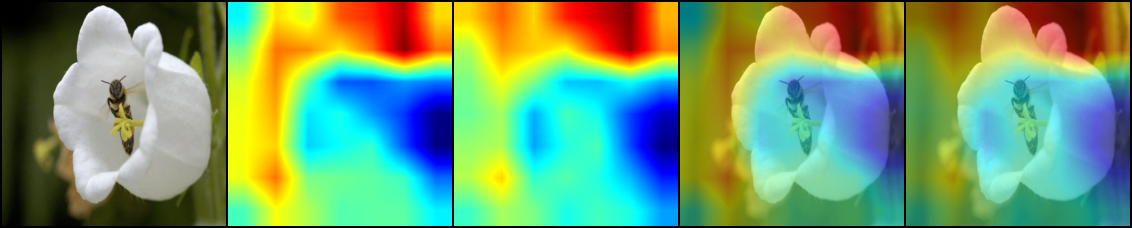

In [ ]:
transforms.ToPILImage()(grid_image[0])

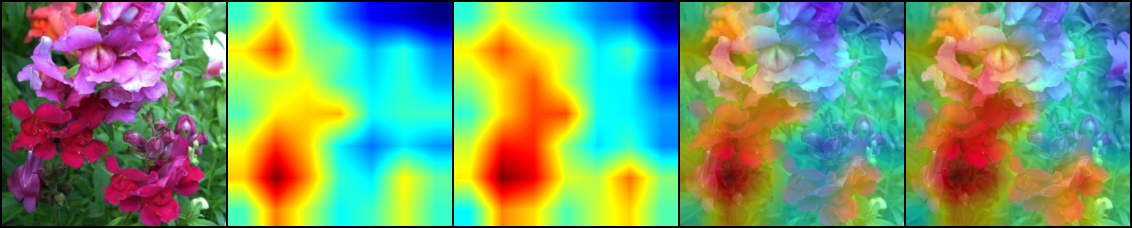

In [ ]:
transforms.ToPILImage()(grid_image[1])

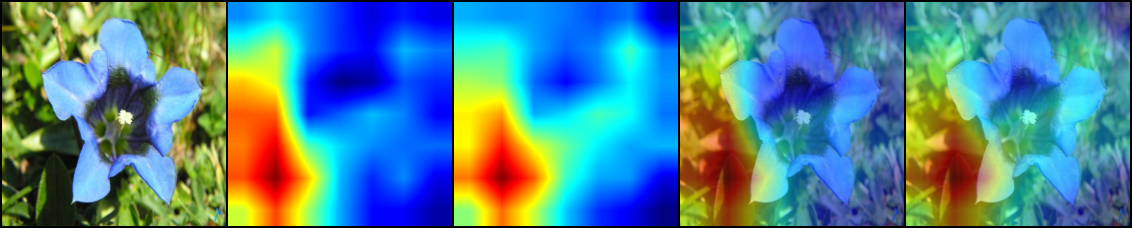

In [ ]:
transforms.ToPILImage()(grid_image[2])

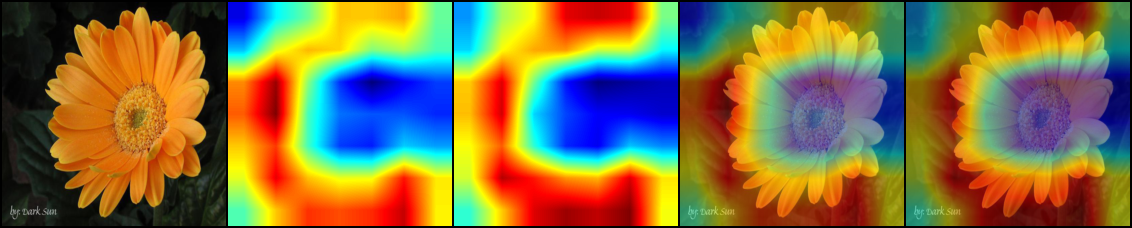

In [ ]:
transforms.ToPILImage()(grid_image[3])

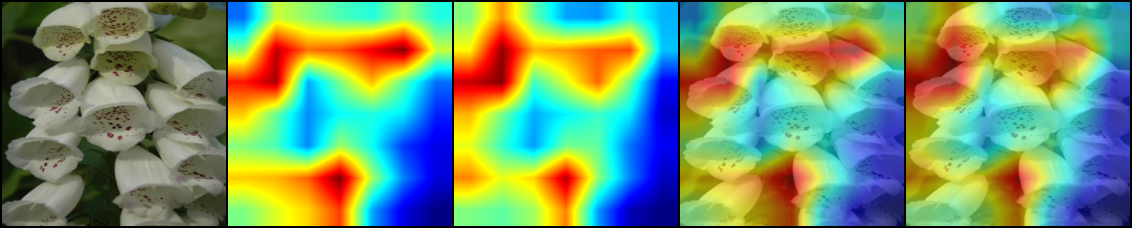

In [ ]:
transforms.ToPILImage()(grid_image[4])

We are seeing the original image as processed by our model in the 1st column of the grid.

Viewing at the above images, we can see that the model is getting better and better at object localization that would eventually be helpful for distinguishing each class. GradCAM++ shows better localization capability (4th and 5th image in the grid) than the GradCAM (2nd and 3rd image in the grid)

#### Suggestions to improve the model:

1. **Hyperparameters:** In order to avoid training for more epochs and still expect better metrics of our model, we should play with our hyperparameters such as the learning rate, batch size, image size, momentum etc. This can be a tediious process and packages such as AutoML can be our best bet to make this task a little feasible
2. **Transformations:** We have applied 2 transformations on our data, namely, ToTensor and RandomResizedCrop. Apart from these, we can apply data agumentations such as flipping of images, random rotation of images, scaling of images, translation etc. Data agumentation is helpful for generating synthetic data from the orginal data hence increasing the overall size of the data and since the data is more, the model learns better because it now has more information and hence it prevents being overfitted on the training data and generlizes well.
3. **Overfitting:** Checking if the model is overfitting on the training data or not can be a huge inidication of where the model can improve. If the training accuracy increases over time and validation accuracy decreases or is flatten over time, it's a clear case of overfitting.
4. **Underfitting:** If the model is underfitted, it may show a flat line of relatively high loss, indicating that the model was unable to learn the training dataset at all.
5. **Feature Engineering:** In order to make the input data compatible with the model, as well as to make the necessary changes to the input data, that might be helpful for the model to converge faster, feature engineering is applied on the input data. For our particular case, feature engineering such as normalising the input images, scaling of images, etc

### Conclusion

Through out this notebook, we see that there are many moving parts of our approach which can be tuned and experiment with.

* We first made sure our data is in the right directory structure.

* Then we visualized a sample of our data to get a better understanding of what kind of data we are dealing with.

* Then we made sure if our data is imbalanced or not as imbalanced data is bad for training of the model since it may overfit or underfit on some or all of the classes

* Then we used a pretrained ResNet50 model and then fine tuned it according to our need.

* After calculating the accuracy of the test set, we visualized the predictions and manually checked what could be the possible reason behind this score.

* The we used GradCAM to inspect which areas the CNN is focusing on and found that it is loacalizing the objects pretty well but it's not very accurate.

* We concluded on the note that the mdoel can be improved by various techniques as suggested by us above